# visualisation in spikeinterface and other tools

spikeinterface have many way to plot every steps (from pre to post processing) of a sorting.

Please have a look to this doc pages:

* https://spikeinterface.readthedocs.io/en/latest/modules/widgets.html
* https://spikeinterface.readthedocs.io/en/latest/viewers.html



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [3]:
from pathlib import Path
import shutil
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.full as si
from probeinterface import generate_multi_columns_probe

In [4]:
base_folder = Path('.').resolve()

wf_folder = (base_folder / 'waveforms_demo_viz')


In [5]:
job_kwargs = dict(n_jobs=-1, chunk_duration='1s', progress_bar=True)

## lets generate a fake dataset

Here a simple way to generate a fake dataset


(-70.0, 120.0)

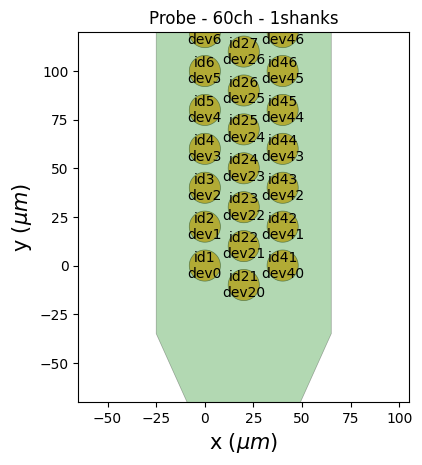

In [6]:
%matplotlib inline

# generate a fake probe
fig, ax = plt.subplots()
probe = generate_multi_columns_probe(
    num_columns=3,
    num_contact_per_column=20,
    xpitch=20,
    ypitch=20,
    y_shift_per_column=[0, -10, 0],
    contact_shapes="circle",
    contact_shape_params={"radius": 8},
    
)
probe.set_contact_ids([f'{i+1}' for i in range(probe.get_contact_count())])
probe.set_device_channel_indices(np.arange(probe.get_contact_count()))


from probeinterface.plotting import plot_probe
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)
ax.set_ylim(-70, 120)

In [9]:
rec, sorting = si.generate_ground_truth_recording(
    durations=[300.0],
    sampling_frequency=30000.,
    probe=probe,
    num_units=120,
    generate_sorting_kwargs={
        'firing_rates': 4,
        'refractory_period_ms': 1.5
    },
    generate_unit_locations_kwargs={
        'margin_um': 10.0,
        'minimum_z': 10.0,
        'maximum_z': 50.0
    },
    seed=2205,
)
rec


InjectTemplatesRecording: 60 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - float32 dtype - 2.01 GiB

In [10]:


if wf_folder.exists():
    shutil.rmtree(wf_folder)

we = si.extract_waveforms(recording=rec, sorting=sorting, folder=wf_folder, sparse=True, **job_kwargs)
si.compute_correlograms(we)
si.compute_unit_locations(we)
si.compute_spike_amplitudes(we, **job_kwargs)
si.compute_template_similarity(we)
si.compute_spike_locations(we)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/300 [00:00<?, ?it/s]

array([(19.29702222, 240.28330404), (20.69639993, 339.0516886 ),
       (21.45300157,  79.75249899), ..., (18.80210324,  28.03396268),
       (19.33988386, 107.10076363), (19.24518759,  39.30226013)],
      dtype=[('x', '<f8'), ('y', '<f8')])

In [11]:
we

WaveformExtractor: 60 channels - 120 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse

##  visualisation with module widget - backend="matplotlib"

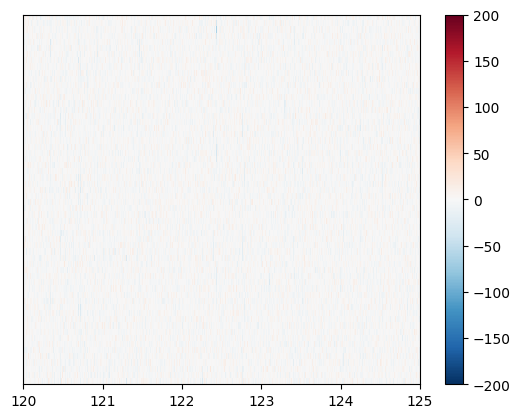

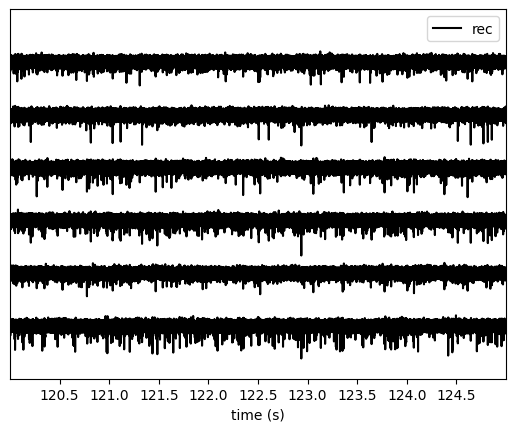

In [12]:
si.plot_traces(rec, time_range=(120, 125), mode='map', backend='matplotlib')
si.plot_traces(rec, time_range=(120, 125), mode='line', channel_ids=rec.channel_ids[::10])

##  visualisation with module widget - backend="ipywidgets"

In [13]:
%matplotlib widget
si.plot_traces(rec, time_range=(120, 125), mode='map', backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## multi layer

In [14]:
%matplotlib widget
rec_processed = si.bandpass_filter(rec, freq_min=300., freq_max = 4000.)
si.plot_traces({'raw': rec, 'processed': rec_processed}, time_range=(10, 10.02),
               mode='line',
               backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

##  visualisation with module widget - backend="sortingview"

In [15]:
rec_processed = si.bandpass_filter(rec, freq_min=300., freq_max = 4000.)
si.plot_traces({'raw': rec, 'processed': rec_processed}, time_range=(10, 10.5),
               mode='map', order_channel_by_depth=True,
               backend='sortingview')

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://79286f98a7ffaf800413182b028694bcfb303ed8


##  visualisation with module widget - backend="ephyviewer"

In [16]:
%gui qt
w = si.plot_traces(rec, mode='line', backend='ephyviewer')

## postprocessing

In [17]:
we = si.load_waveforms(wf_folder)

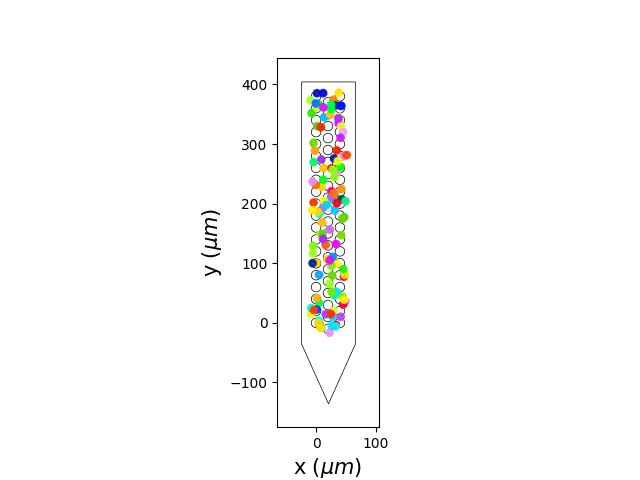

In [18]:
si.plot_unit_locations(we)

In [19]:
%matplotlib widget
# si.plot_unit_waveforms(we, backend='matplotlib')
si.plot_unit_waveforms(we, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/widgets/unit_waveforms_density_map.py:116: RuntimeWarning: invalid value encountered in cast
  wf_bined = np.floor((wfs_flat - bin_min) / bin_size).astype("int32")


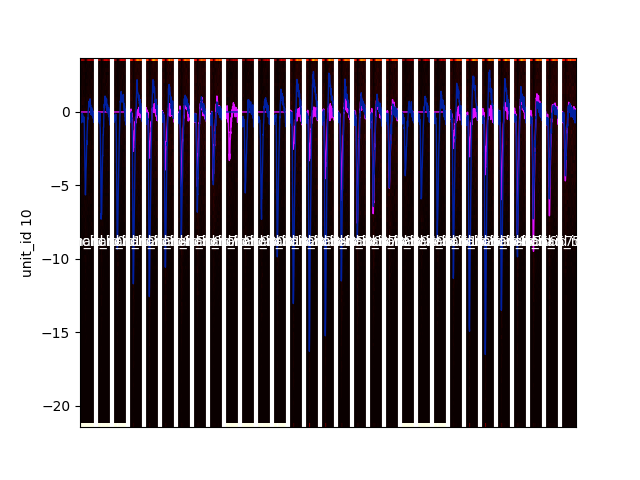

In [20]:
%matplotlib widget
si.plot_unit_waveforms_density_map(we, backend='matplotlib', unit_ids=we.unit_ids[10:12], same_axis=True)

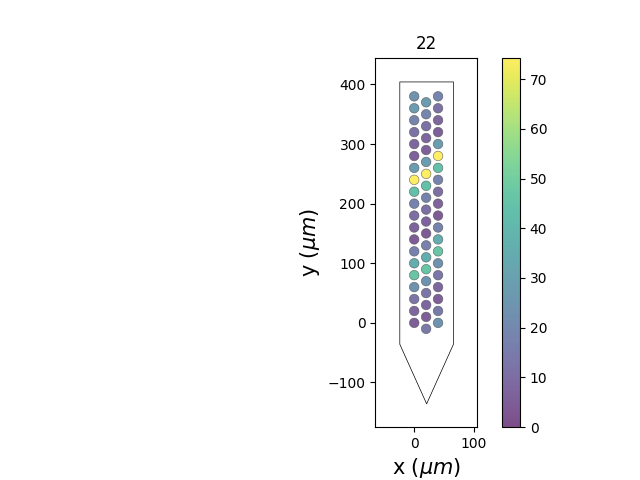

In [21]:
%matplotlib widget
si.plot_unit_probe_map(we,unit_ids=we.unit_ids[22:23])

In [22]:
%matplotlib widget
si.plot_amplitudes(we,unit_ids=we.unit_ids[22:23], backend='ipywidgets')

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

In [23]:
%matplotlib widget
si.plot_spike_locations(we, backend='ipywidgets')

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

## Summary with spikeinterface-gui

In [25]:
%gui qt
!sigui {wf_folder}

## Summary with sorting view

In [26]:
si.plot_sorting_summary(we, backend='sortingview')

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://38e516cc885b72bc2ef6afa0c4a4eb6681f28c12


## export to phy

phy used to be areference for manual curation but this is not maintened anymore.

In [27]:
phy_folder = (base_folder / 'phy_folder')

if not phy_folder.exists():
    si.export_to_phy(we, output_folder=phy_folder,
                     compute_pc_features=False,
                     compute_amplitudes=True,
                     copy_binary=False,
                     **job_kwargs)

    
    

In [29]:
! phy template-gui  {phy_folder}/params.py

17:42:16.822 [W] model:1408           File /home/samuel/Documents/SpikeInterface/school_spike_sorting_marseille_2023/Practice_visualisation/phy_folder/None does not exist.
17:42:16.873 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
17:42:16.874 [W] traces:462           File /home/samuel/Documents/SpikeInterface/school_spike_sorting_marseille_2023/Practice_visualisation/phy_folder/None does not exist.
17:42:16.874 [W] traces:462           File /home/samuel/Documents/SpikeInterface/school_spike_sorting_marseille_2023/Practice_visualisation/phy_folder/None does not exist.
17:42:16.977 [I] state:180            Copied /home/samuel/Documents/SpikeInterface/phy/phy/apps/template/static/state.json to /home/samuel/.phy/TemplateGUI/state.json.
17:42:17.218 [W] gui:671              Could not create view FeatureView.
17:42:17.257 [W] gui:671              Could not create view TraceView.
17:42:17.273 [W] gui:671   